In [3]:
import pandas as pd
import requests
import time
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:


# Function to get the maximum item ID
def get_max_item_id():
    response = requests.get('https://hacker-news.firebaseio.com/v0/maxitem.json')
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to get max_item_id. Exiting.")
        return None

# Initialize DataFrame to hold all the items
df = pd.DataFrame()

# Initialize max_item_id with the current maximum item id from the API
max_item_id = get_max_item_id()
current_id = max_item_id
step_size = 1
post_capacity = 1000

print(f"Starting to fetch items from item ID {max_item_id} until {max_item_id-post_capacity}.")


# Loop through item IDs from max_item_id to 1
for item_id in range(current_id, (current_id-post_capacity), -1):
    
    print(f"Fetching data for item ID {item_id}...")
    
    # Fetch item data from API
    item_url = f"https://hacker-news.firebaseio.com/v0/item/{item_id}.json"
    response = requests.get(item_url)
    
    if response.status_code == 200:
        item_data = response.json()
        if item_data is not None:      
            # Append to DataFrame
            df = pd.concat([df, pd.DataFrame([item_data])], ignore_index=True)
        else:
            print(f"No data for item ID {item_id}. Skipping.")
            current_id -= step_size
    else:
        print(f"Failed to fetch data for item ID {item_id}")
    
    
    # Add sleep to respect rate limits if any
    time.sleep(0.1)

print(f"Finished fetching items")

# Save DataFrame to Parquet format
df.to_parquet('hacker_news_Mini.parquet')
print("Saved data to hacker_news_2022.parquet.")



In [10]:



# Open Parquet file
hacker_news_Mini_parquet_file = pq.ParquetFile('hacker_news_Mini.parquet')

# Access file metadata
file_metadata = hacker_news_Mini_parquet_file.metadata

# Print some file-level details
print(f"Schema: {file_metadata.schema}")
print(f"Number of rows: {file_metadata.num_rows}")
print(f"Number of row groups: {file_metadata.num_row_groups}")



Schema: <pyarrow._parquet.ParquetSchema object at 0x000001F3E69DBF40>
required group field_id=-1 schema {
  optional binary field_id=-1 by (String);
  optional int64 field_id=-1 id;
  optional double field_id=-1 parent;
  optional binary field_id=-1 text (String);
  optional int64 field_id=-1 time;
  optional binary field_id=-1 type (String);
  optional boolean field_id=-1 dead;
  optional double field_id=-1 score;
  optional double field_id=-1 descendants;
  optional binary field_id=-1 title (String);
  optional binary field_id=-1 url (String);
  optional group field_id=-1 kids (List) {
    repeated group field_id=-1 list {
      optional int64 field_id=-1 element;
    }
  }
  optional boolean field_id=-1 deleted;
}

Number of rows: 1000
Number of row groups: 1


In [13]:
import pyarrow.parquet as pq

# Open the Parquet file
parquet_file = pq.ParquetFile('hacker_news_Mini.parquet')

# Access schema to get metadata
schema = parquet_file.schema

# Get metadata for the first column
column_metadata = schema[1]

# Print some column-level details
print(f"Column name: {column_metadata.name}")
print(f"Column physical type: {column_metadata.physical_type}")



Column name: id
Column physical type: INT64


In [9]:
# Access metadata for a specific row group
row_group_metadata = file_metadata.row_group(0)

# Print some row group details
print(f"Number of columns: {row_group_metadata.num_columns}")
print(f"Number of rows: {row_group_metadata.num_rows}")

Number of columns: 13
Number of rows: 1000


In [14]:
# Read only the 'col1' column
df_pruned = pd.read_parquet('hacker_news_Mini.parquet', engine='pyarrow', columns=['by','id'])
df_pruned

,by,id
0,Kuinox,37856355
1,housecarpenter,37856354
2,goeiedaggoeie,37856353
3,vibhuti_k,37856352
4,nrclark,37856351
...,...,...
995,limbicsystem,37855360
996,medianwaterr,37855359
997,hardware2win,37855358
998,pjmlp,37855357


In [16]:
# Using PyArrow to apply predicate pushdown
table = pq.read_table('hacker_news_Mini.parquet', filters=[('id', '>', 37856353)])
df_filtered = table.to_pandas()
df_filtered

,by,id,parent,text,time,type,dead,score,descendants,title,url,kids,deleted
0,Kuinox,37856355,37856315.0,"It&#x27;s not feasibly impossible, it&#x27;s v...",1697114357,comment,None,NaN,NaN,None,None,None,None
1,housecarpenter,37856354,37847466.0,I would interpret &quot;accessible&quot; here ...,1697114356,comment,None,NaN,NaN,None,None,None,None


In [18]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

# Load the existing Parquet file into a DataFrame
df = pd.read_parquet('hacker_news_Mini.parquet')

# Write DataFrame to a partitioned Parquet dataset
# Replace 'col1' with the column you want to partition by
pq.write_to_dataset(pa.table(df), root_path='partitioned_dataset', partition_cols=['type'])


In [4]:
#make df a dataframe
df = pd.read_parquet('hacker_news_Mini.parquet')

In [12]:
# Write DataFrame to Parquet with Gzip compression
df.to_parquet('compressed/example_gzip.parquet', engine='pyarrow', compression='gzip')

In [11]:
# Write DataFrame to Parquet with Snappy compression
df.to_parquet('compressed/example_snappy.parquet', engine='pyarrow', compression='snappy')

In [13]:
# Write DataFrame to Parquet with LZ4 compression
df.to_parquet('compressed/example_lz4.parquet', engine='pyarrow', compression='lz4')

In [14]:
#read the size of the parquet files in compressed folder
import os
print("Size of Gzip compressed file: ", os.path.getsize('compressed/example_gzip.parquet'))
print("Size of Snappy compressed file: ", os.path.getsize('compressed/example_snappy.parquet'))
print("Size of LZ4 compressed file: ", os.path.getsize('compressed/example_lz4.parquet'))


Size of Gzip compressed file:  173067
Size of Snappy compressed file:  264011
Size of LZ4 compressed file:  267742


Time taken to read Gzip compressed file: 0.009032726287841797 seconds
Time taken to read Snappy compressed file: 0.006046295166015625 seconds
Time taken to read LZ4 compressed file: 0.004781007766723633 seconds
Time taken to read uncompressed file: 0.0060079097747802734 seconds


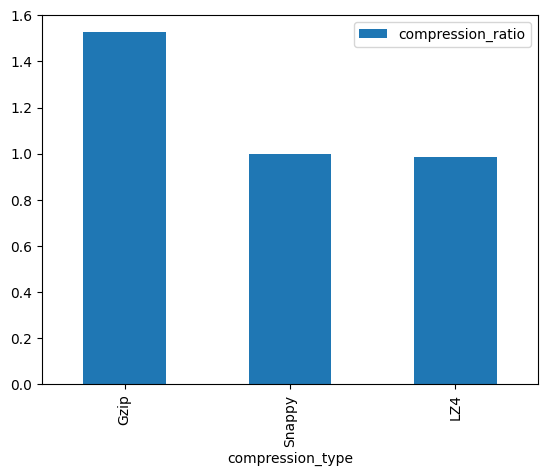

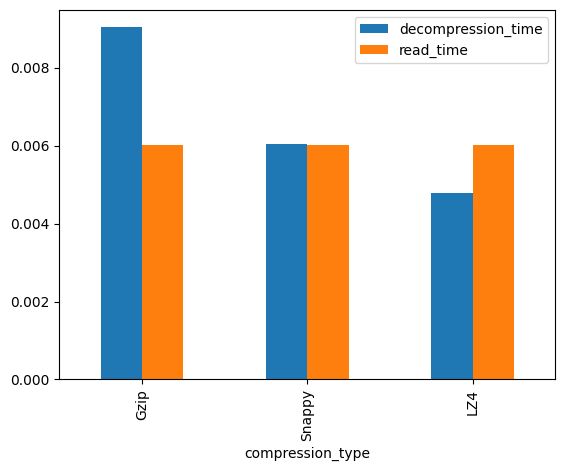

In [19]:
#try to query the compressed parquet files and see the time it takes
import time

# Read the Gzip compressed file
start = time.time()
df_gzip = pd.read_parquet('compressed/example_gzip.parquet')
end = time.time()
gziptime = end-start
print(f"Time taken to read Gzip compressed file: {end-start} seconds")

# Read the Snappy compressed file
start = time.time()
df_snappy = pd.read_parquet('compressed/example_snappy.parquet')
end = time.time()
snappytime = end-start
print(f"Time taken to read Snappy compressed file: {end-start} seconds")

# Read the LZ4 compressed file
start = time.time()
df_lz4 = pd.read_parquet('compressed/example_lz4.parquet')
end = time.time()
lz4time = end-start
print(f"Time taken to read LZ4 compressed file: {end-start} seconds")

# Read the uncompressed file
start = time.time()
df = pd.read_parquet('hacker_news_Mini.parquet')
end = time.time()
uncompressedtime = end-start
print(f"Time taken to read uncompressed file: {end-start} seconds")

# compare the time it takes to read the compressed and uncompressed files and make a plot
import matplotlib.pyplot as plt

# Create a list of compression ratios

compression_ratios = [os.path.getsize('hacker_news_Mini.parquet')/os.path.getsize('compressed/example_gzip.parquet'),
                        os.path.getsize('hacker_news_Mini.parquet')/os.path.getsize('compressed/example_snappy.parquet'),
                        os.path.getsize('hacker_news_Mini.parquet')/os.path.getsize('compressed/example_lz4.parquet')]
compression_ratios

# Create a list of decompression times

decompression_times = [gziptime, snappytime, lz4time]
decompression_times

# Create a list of read times

read_times = [uncompressedtime, uncompressedtime, uncompressedtime]
read_times

# Create a list of compression types

compression_types = ['Gzip', 'Snappy', 'LZ4']
compression_types

# Create a DataFrame from compression_ratios, decompression_times, read_times, and compression_types
df = pd.DataFrame({'compression_ratio': compression_ratios, 'decompression_time': decompression_times, 'read_time': read_times, 'compression_type': compression_types})
df

# Plot the DataFrame as a bar chart
df.plot(x='compression_type', y=['compression_ratio'], kind='bar')
plt.show()

df.plot(x='compression_type', y=['decompression_time', 'read_time'], kind='bar')

plt.show()